In [1]:
import mido
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.insert(0, '../scripts')

import stft_zoom, display
from util import fft_frequencies
import mappings
import pickle
import PIL
import IPython.display
import detect_musical_regions

In [2]:
midi = mido.MidiFile('../../../maestro-dataset/maestro-v2.0.0/2014/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--2.midi')
y, sr = librosa.load('../../../maestro-dataset/maestro-v2.0.0/2014/MIDI-UNPROCESSED_01-03_R1_2014_MID--AUDIO_03_R1_2014_wav--2.wav', sr=44100)

In [3]:
def midi_to_piano_roll_new(midi_file, decay=False, decay_rate=28):
    # decay determines if a linear velocity decay rate will be applied to all notes (TO DO)
    # decay_rate is given in velocity per second


    # From a midi file, build a 2D array representing the piano roll
    decay_per_tick = decay_rate / mido.second2tick(1, tempo=500000, ticks_per_beat=midi_file.ticks_per_beat)
    ticks_in_track = np.ceil(mido.second2tick(midi_file.length, tempo=500000, ticks_per_beat=midi_file.ticks_per_beat))
    piano_roll = np.zeros([127, int(ticks_in_track)])   # piano roll with x axis labeled by ticks and y axis labeled by midi note number

    time = 0
    pedal_flag = False           # True if sustain pedal is pressed, 0 otherwise
    noteon_vel = np.zeros(127)   # velocity of pressed keys
    noteon_time = np.zeros(127, dtype='int') # time key was pressed
    keyrelease_flags = []

    for msg in midi_file.tracks[1]:
        time += msg.time
        if msg.type == 'note_on':
            if msg.velocity > 0:
                noteon_vel[msg.note] = msg.velocity
                noteon_time[msg.note] = time
            else: # note-off (note-offs are given as note-on events with velocity==0)
                if pedal_flag: # key was released, but sustain pedal keeps it sounding
                    keyrelease_flags.append(msg.note) # notes contained here will cease when sustain pedal is released
                else:
                    piano_roll[msg.note, noteon_time[msg.note]:time] = noteon_vel[msg.note]
        elif msg.type == 'control_change':
            if not pedal_flag and msg.value>0: # pedal sends several messages during one pressing motion
                pedal_flag = True
            elif pedal_flag and msg.value == 0:
                pedal_flag = False
                for note in keyrelease_flags: # these notes stopped playing
                    piano_roll[note, noteon_time[note]:time] = noteon_vel[note]
                    keyrelease_flags = []
                
    return piano_roll

In [4]:
piano_roll = midi_to_piano_roll_new(midi)

In [5]:
end = mido.second2tick(20, tempo=500000, ticks_per_beat=midi.ticks_per_beat)

In [6]:
piano_roll = piano_roll[:,:int(end)]

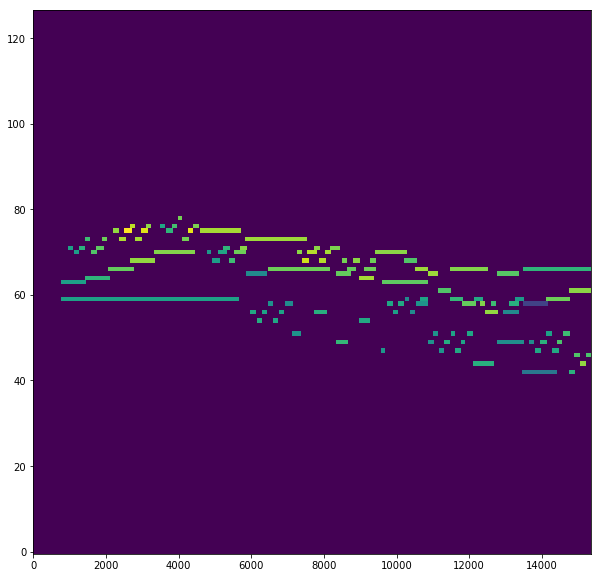

In [7]:
plt.figure(figsize=[10,10])
plt.imshow(piano_roll, origin='lower', aspect='auto')

In [8]:
y = y[:sr*20]

In [9]:
from mappings import *
from aug_density_map import *

In [10]:
n_fft = 2048
hop_size = 512
kernel = [500,500]

spec = librosa.stft(y, n_fft=2048)
proll_aug_den = calc_map_aug2(sound_event_to_tfp(compose_sound_event_map_aug(midi_to_piano_roll_augmented(midi, 0)), spec.shape[1], n_fft=n_fft), kernel, type='avg', n_fft=n_fft, hop_size=hop_size)

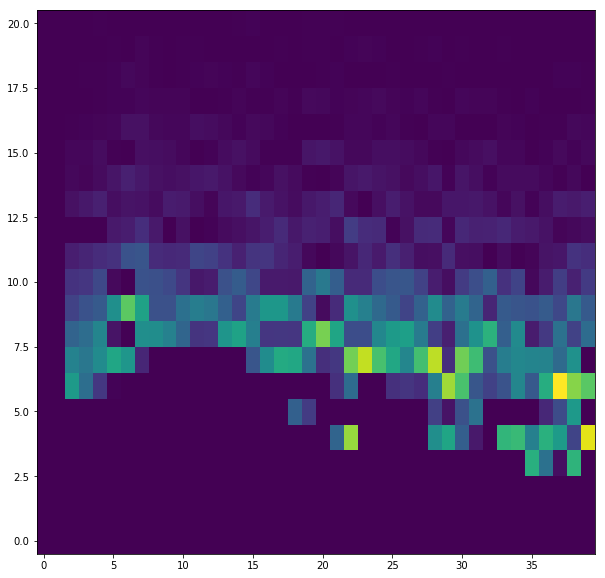

In [11]:
plt.figure(figsize=[10,10])
plt.imshow(proll_aug_den, origin='lower', aspect='auto')

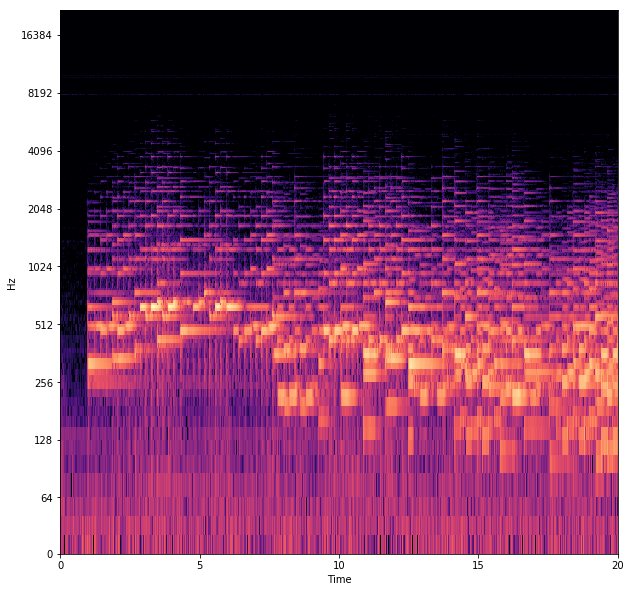

In [13]:
plt.figure(figsize=[10,10])
spec_db = librosa.amplitude_to_db(spec, ref=np.max)
librosa.display.specshow(spec_db, y_axis='log', sr=sr, hop_length=512, x_axis='time')

In [25]:
entropy = calc_map_aug2(spec_db, kernel, type='renyi')

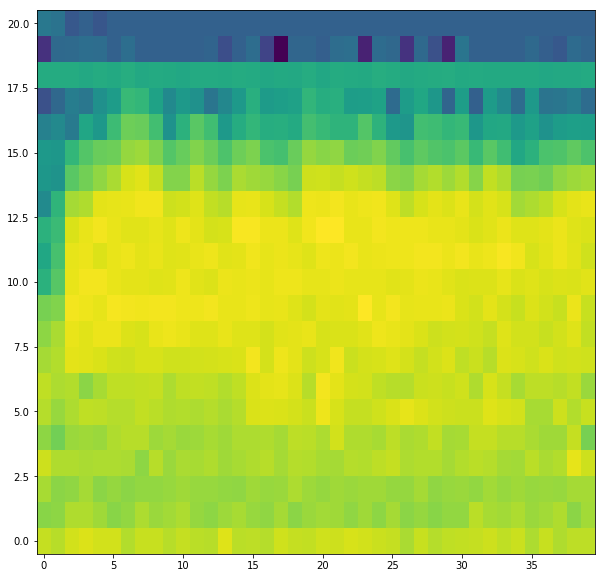

In [26]:
plt.figure(figsize=[10,10])
plt.imshow(entropy, origin='lower', aspect='auto')

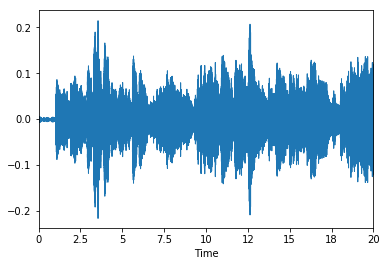

In [27]:
librosa.display.waveplot(y, sr=sr)